In [1]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
seed = 72
torch.manual_seed(seed)         
torch.cuda.manual_seed(seed)    
print("hi")

hi


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import torch
from torch import nn
import torch.optim as optim 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import random
from skimage.transform import resize
import cv2
import torchvision

Here you have to

In [8]:
import opendatasets as od
import pandas

od.download(
	"https://www.kaggle.com/datasets/nih-chest-xrays/data")


100%|██████████| 42.0G/42.0G [03:48<00:00, 197MB/s]


#☕ **Loading the dataset & preprocessing the data**

let's get the X-ray scans and the lables from the NIH dataset, analyze it and preprocess it

In [9]:
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data', 'images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
91626,00022839_002.png,No Finding,2,22839,65,M,AP,3056,2544,0.139,0.139,NaN,data/images_010/images/00022839_002.png
70151,00017268_000.png,No Finding,0,17268,60,M,PA,2992,2991,0.143,0.143,NaN,data/images_008/images/00017268_000.png
88376,00021867_000.png,No Finding,0,21867,41,M,PA,2650,2991,0.143,0.143,NaN,data/images_010/images/00021867_000.png


##  standardizing the Patient Age
 
 as said, we would like to standardize the age such that  $\mu = 0$ , $\sigma = 1$
 but first, let's verify that the distribution even resambles a normal one:

16.839847435450604


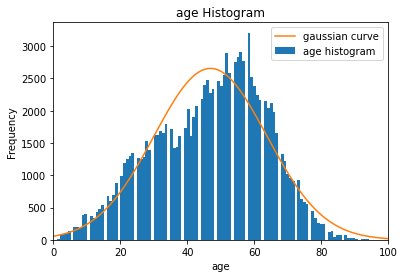

In [10]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])
print(sigma)


plt.hist(all_xray_df['Patient Age'], bins=500)

plt.gca().set(title='age Histogram', ylabel='Frequency',xlabel = 'age');
plt.xlim([0, 100])

x_data = np.arange(0, 100, 0.001)

## y-axis as the gaussian
y_data = stats.norm.pdf(x_data, mu, sigma)*len(all_xray_df['Patient Age'])


plt.plot(x_data,y_data)
plt.legend(["gaussian curve","age histogram"])

seems pretty close, let us standardize it

In [11]:
print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

all_xray_df['Patient Age'] = (all_xray_df['Patient Age'])/ sigma - mu/sigma


𝜇 = 46.90146271851587,	 𝜎 = 16.839847435450604


now compute and display the new $\mu $ and $\sigma $


In [12]:
mu = np.mean(all_xray_df['Patient Age'])
sigma = np.std(all_xray_df['Patient Age'])

print(f'𝜇 = {mu},\t 𝜎 = {sigma}')

𝜇 = 2.911374712880753e-16,	 𝜎 = 1.0


let's view the difference in our dataset

In [13]:
all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
30422,00007935_000.png,No Finding,0,7935,-0.884893,F,PA,2684,2627,0.143000,0.143000,NaN,data/images_004/images/00007935_000.png
33288,00008727_025.png,No Finding,25,8727,0.540298,M,PA,2992,2991,0.143000,0.143000,NaN,data/images_004/images/00008727_025.png
73426,00018055_044.png,No Finding,44,18055,1.015362,M,PA,2021,2021,0.194308,0.194308,NaN,data/images_008/images/00018055_044.png


## Adjusting the output
Here we take the labels and make them into a more clear format. what's most important for us right now is to devide our label values into 2: cardiomegali diagnosed or "No finding".

In [14]:
all_xray_df['Finding Labels'] = [x.split("|") for x in all_xray_df['Finding Labels']]


In [15]:
all_xray_df['Cardiomegaly'] = [('Cardiomegaly' in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df['No Finding'] = [('No Finding' in x)*1 for x in all_xray_df['Finding Labels']]

print(f"number of patients diagnosed with cardiomegaly: {np.sum(all_xray_df['Cardiomegaly'])}")
print(f"number of patients diagnosed with No Finding: {np.sum(all_xray_df['No Finding'])}")

number of patients diagnosed with cardiomegaly: 2776
number of patients diagnosed with No Finding: 60361


1
1
1
0


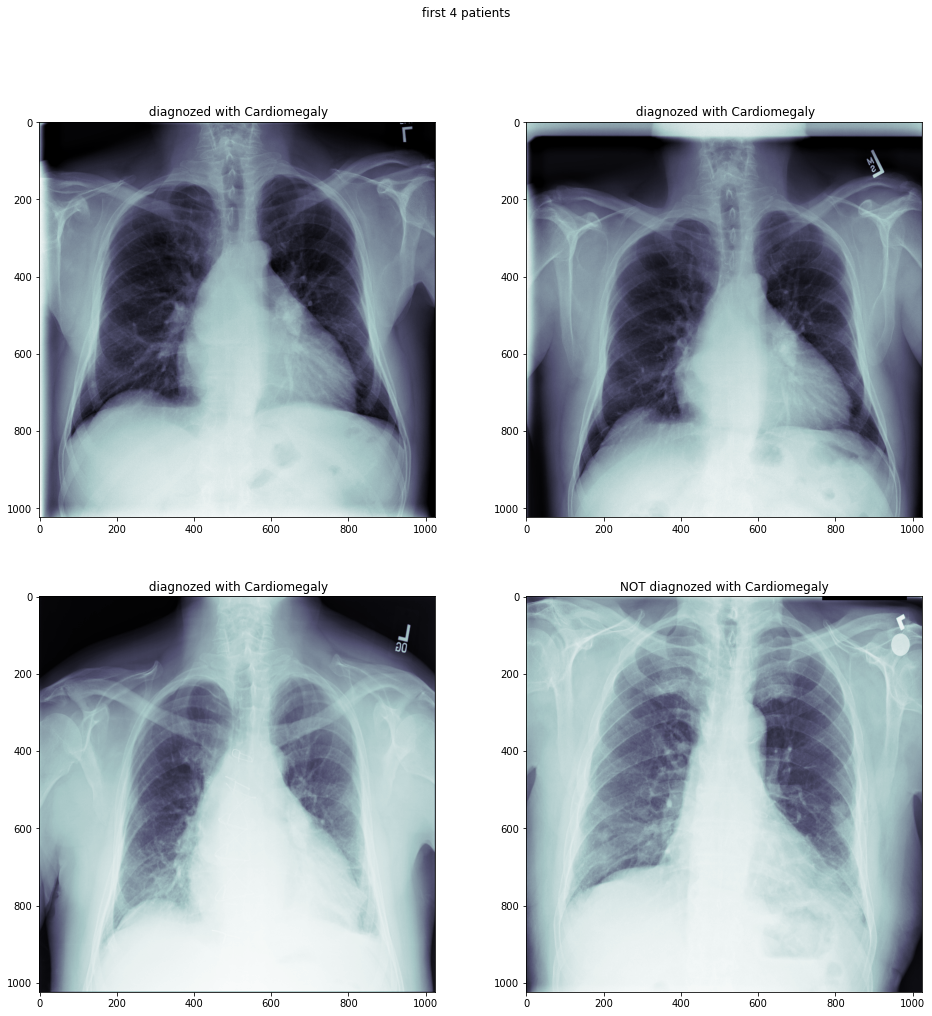

In [16]:
with_cardio = [plt.imread(all_xray_df['path'][i]) for i in range(4)]
# plt.imshow(with_cardio,cmap = 'bone')


fig, m_axs = plt.subplots(2, 2,figsize = (16, 16))
fig.suptitle('first 4 patients')

for i, ax in enumerate(m_axs.flatten()):
    
    print(all_xray_df['Cardiomegaly'][i])
    ax.imshow(with_cardio[i],cmap = 'bone')
    ax.set_title(f"{'NOT'*(not all_xray_df['Cardiomegaly'][i])} diagnozed with Cardiomegaly")



In [17]:
s = set()
d = {}
for p in all_xray_df['Finding Labels']:
  for x in p:
    #print(x)
    s.add(x)
    if d[x]

print(s)

SyntaxError: ignored

In [ ]:
corr_df = pd.DataFrame()

corr_df['Infiltration'] = [('Infiltration' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Cardiomegaly'] = [('Cardiomegaly' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Nodule'      ] = [('Nodule' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pneumonia'   ] = [('Pneumonia' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Consolidation'] = [('Consolidation' in x)*1 for x in all_xray_df['Finding Labels']]
#corr_df['No Finding'  ] = [('No Finding' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Hernia'      ] = [('Hernia' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pleural_Thickening'] = [('Pleural_Thickening' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Fibrosis'    ] = [('Fibrosis' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Atelectasis' ] = [('Atelectasis' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Pneumothorax'] = [('Pneumothorax' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Emphysema'   ] = [('Emphysema' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Edema'       ] = [('Edema' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Mass'        ] = [('Mass' in x)*1 for x in all_xray_df['Finding Labels']]
corr_df['Effusion'    ] = [('Effusion' in x)*1 for x in all_xray_df['Finding Labels']]

for pathologie in s:
  print(f'corr_df[\'{pathologie}\'] = [(\'{pathologie}\' in x)*1 for x in all_xray_df[\'Finding Labels\']]')


In [ ]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "a"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


df = pd.DataFrame()
plotCorrelationMatrix(corr_df,14)

we want to resize the image so we check the image features for (200,200)

In [ ]:
img = plt.imread(all_xray_df['path'][0])
img=resize(img,(200,200))
plt.imshow(img)

In [ ]:
all_xray_df['Gender'] =  [0 if g =='M' else 1 for g in all_xray_df['Patient Gender']]
all_xray_df['position'] =  [0 if g =='AP' else 1 for g in all_xray_df['View Position']]
all_xray_df.sample(3)

## Building the balanced Cardiomegali dataset

*   we take positive cases and for the sake of balancing the data, we take a close amount for the negative cases.

*   as a balnce vs. dataset size trade off,  we take $ξ$ more negative cases to enlarge the total size. 



In [ ]:
mask = all_xray_df['Cardiomegaly'] == 1
positive = all_xray_df.loc[mask]
positive = positive.reset_index(drop=True)

neg_mask = all_xray_df['No Finding'] == 1
negative = all_xray_df.loc[neg_mask]
negative = negative.sample(frac=1).reset_index(drop=True)


#chosen_idx = np.random.choice(len(negative), replace = False, size = int(n*1.2))




## Split the Data to Train, Valid and Test



*   positive - "cardiomegaly"

*   negative - "No findings"




In [ ]:
TRAINSIZE = 0.86
VALSIZE = 0.93


p =len(positive)
n = len(negative)
N = n+p


data = pd.concat([positive,negative]).sample(frac=1).reset_index(drop=True)


pos_train, pos_test, pos_val = positive.iloc[:int(TRAINSIZE*p)], positive.iloc[int(TRAINSIZE*p):int(VALSIZE*p)],positive.iloc[int(VALSIZE*p):]
neg_train, neg_test, neg_val = negative.iloc[:int(TRAINSIZE*n)], negative.iloc[int(TRAINSIZE*n):int(VALSIZE*n)],negative.iloc[int(VALSIZE*n):n]
data_train, data_test, data_val = data.iloc[:int(TRAINSIZE*N)], data.iloc[int(TRAINSIZE*N):int(VALSIZE*N)],data.iloc[int(VALSIZE*N):]

data_train = data_train.reset_index(drop=True)
pos_train = pos_train.reset_index(drop=True)
neg_train = neg_train.reset_index(drop=True)

data_test = data_test.reset_index(drop=True)
pos_test = pos_test.reset_index(drop=True)
neg_test = neg_test.reset_index(drop=True)

data_val = data_val.reset_index(drop=True)
pos_val = pos_val.reset_index(drop=True)
neg_val = neg_val.reset_index(drop=True)
pos_val


## Transforming the Dataset to Tensors

Our data is stored in collabs hard disc what cause high runtime, we will write a function that will store the train, val, test images in tensors.

In [ ]:
def collect_tensor(data,H,W):
  n=len(data)
  data_array = torch.zeros((n,H,W))
  variables = torch.zeros((n,3))

  for j in range(n):
    if plt.imread(data['path'][j]).shape==(1024,1024):
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960],(H,W)))   
    else:
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[144:960,80:960,0],(H,W)))
    
    
    variables[j,0] = data['Patient Age'][j]
    variables[j,1] = data['Gender'][j]
    variables[j,2] = data['position'][j]

  return data_array, variables
     


In [ ]:
H=224
W=224
"""
pos_train_arr , vars_pos_train_arr = collect_tensor(pos_train,H,W)

pos_test_arr , vars_pos_test_arr = collect_tensor(pos_test,H,W)

pos_val_arr  , vars_pos_val_arr = collect_tensor(pos_val,H,W)

neg_train_arr  , vars_neg_train_arr = collect_tensor(neg_train[:2500],H,W)

neg_test_arr ,vars_neg_test_arr = collect_tensor(neg_test[:300],H,W)

neg_val_arr  ,vars_neg_val_arr = collect_tensor(neg_val[:300],H,W)
"""

For testing the data we will try to look for different crops for the image, and different resizes to decide what transformation our good for the data.

In [ ]:
m, n =20, 5 
fig, axs = plt.subplots(m, n, figsize= (n*3,m*4))
for i in range(100):
  plt.figure()
  axs[i//n,i%n].imshow(resize(plt.imread(pos_train['path'][i])[144:960,80:960],(200,200)))

  

In [ ]:
a = cv2.cvtColor(resize(plt.imread(pos_train['path'][0])[144:960,80:960],(200,200)),cv2.COLOR_GRAY2BGR)

## ????

We will write a function which will generate positive/negative tensor batches for the accuracy check function.

In [ ]:
def generate_batch_tensor(data):
   n=len(data)
   xt = torch.zeros((n,224,224))
   vars = torch.zeros((n,3))
   for j in range(n):  
      xt[j]=data[j]
      #vars[j][0]=data[j][1]
      #vars[j][1]=data[j][2]
      #vars[j][2]=data[j][3]
      
   xt=xt.reshape(n,224,224,1)
   xt=torch.cat((xt,xt,xt),3)
   xt=xt.reshape(n,3,224,224)
   

   return xt,vars          
  


vectorizing the gender column

### bold text **TODO** we need to figure out how to demonstrate / prove correlation between gender and cardio.

if there is none, remove the column 

In [ ]:
fu_mean = np.mean(all_xray_df['Follow-up #'])
fu_mean_cardio = np.mean(all_xray_df.loc[all_xray_df['Cardiomegaly'] == True]['Follow-up #'])

print(f'followup mean in dataset:{fu_mean}\nfollowup mean for diagnosed patients:{fu_mean_cardio}\n')



# 🕸 **Network architecture**

Now we will build the architecture of the model.

important to mention that we used some image shapes: 1024X1024, 880X816, 200X200.

**BLOCK 1:**



*   Convolutional layer (nn.Conv2D(in_channels, num_hidden,kernel_size=(3,3), stride=(2,2)))

*   Batch Normalization(num_hidden)




*   MaxPool2d(kernel_size=2, stride=2))

*   Activation Function: nn.ReLU()







**BLOCK 2:**






*   Convolutional layer (nn.Conv2D(num_hidden, num_hidden * 2, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 2)
*   MaxPool2d(kernel_size=2, stride=2))



**BLOCK 3:**


*   Convolutional layer (nn.Conv2D(num_hidden * 2, num_hidden * 4, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()

*   Batch Normalization(num_hidden * 4)


 
**BLOCK 4:**


*   Convolutional layer (nn.Conv2D(num_hidden * 4, num_hidden * 8, kernel_size=(3,3), stride=(2,2))

*   Activation Function: nn.ReLU()



*   Batch Normalization(num_hidden * 8)











**BLOCK 5:**


*   FC layer(3 * 3 * 8 * num_hiddens,100)

*   Activation Function: nn.Sigmoid()

*   FC layer(100,20)

*   Activation Function: nn.Sigmoid())




**BLOCK 6:**

In this chapter we add the arguments: [Age,Gender,angle]
                           

*   FC layer(20 + num_vars, 2)
*   nn.Sigmoid()





input size: 1024x1024

In [ ]:
W,H = 1024,1024

class CNN1(nn.Module):
    def __init__(self, num_hiddens,num_vars):

        
        super(CNN, self).__init__()

        H = 1024
        W = 1024
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.ReLU())
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.ReLU())

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*4),
                                    nn.ReLU())
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.BatchNorm2d(num_hiddens*8),
                                    nn.ReLU())


        self.fc_block1 = nn.Sequential(nn.Linear((W//16)*(H//16)*8*num_hiddens,100), #flatten the CNN output -> Block 5
                                       nn.Sigmoid(),
                                       nn.Linear(100,20),
                                       nn.Sigmoid())
        
        self.fc_block2 =  nn.Sequential(nn.Linear(20 + num_vars, 10), #flatten the CNN output -> Block 6
                                       nn.Sigmoid(),
                                       nn.Linear(10,2),
                                       nn.Sigmoid())
         

    def forward(self,x,vars):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,(W//16)*(H//16)*8*self.num_hiddens) # reshape for tensor
        x = self.fc_block1(x)
        x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x




input size: $224 𝗑 224$


In [ ]:
model= CNN(3,2)
model.forward(lst_train[0])

## **Evaluation function**

We will test the accuracy of the positive and negative separately.



In [ ]:
path_saving  = '/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio'

In [ ]:
def get_accuracy(model, pos,neg,batch_size=50):
    """Compute the model accuracy on the data set. This function returns two
    separate values: the model accuracy on the positive samples,
    and the model accuracy on the negative samples.

    Example Usage:

    >>> model = CNN() # create untrained model
    >>> pos_acc, neg_acc= get_accuracy(model, valid_data)
    >>> false_positive = 1 - pos_acc
    >>> false_negative = 1 - neg_acc
    """
    len_pos= len(pos)
    len_neg=len(neg)
    model.eval()
    acc_pos=0
    acc_neg=0
    H=224
    W=224
      
    pos_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
          break
        acc_pos += batch_size
        xs , var_xs = generate_batch_tensor(pos[i:i+batch_size])
        if torch.cuda.is_available():
            xs , var_xs = xs.cuda() , var_xs.cuda()
        #zs = model(xs,var_xs)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        pos_correct += (pred == 1).sum()
    
    neg_correct = 0
    for i in range(0, len_pos, batch_size):
        if (i+batch_size)>len_pos:
            break
        acc_neg += batch_size
        xs , var_xs = generate_batch_tensor(neg[i:i+batch_size])
        if torch.cuda.is_available():
            xs , var_xs = xs.cuda() , var_xs.cuda()
        #zs = model(xs,var_xs)
        zs = model(xs)
        pred = zs.max(1, keepdim=True)[1] # get the index of the max logit
        pred = pred.detach().cpu().numpy()
        neg_correct += (pred == 0).sum()

    return pos_correct/acc_pos, neg_correct/acc_neg

## **Training function**

While training the different models we had to modify the training function multiple times.



In [ ]:
def nn_train(model,
              p_train = pos_train_arr,
              n_train = neg_train_arr,
              p_val = pos_val_arr,
              n_val = neg_val_arr,
              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=None,
              vars = False
              ):
#main training loop; choice of loss function; choice of optimizer
  #print("hi")

 
  criterion = nn.CrossEntropyLoss()
  criterion = criterion.cuda()
  
  
  optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay,
                           momentum=0.9)
  
  iters, losses = [], []
  iters_sub, train_accs_pos , train_accs_neg, val_accs_pos, val_accs_neg  = [], [] ,[],[],[]
  
  len_data= min(len(p_train),len(n_train))
  acc_len_pos=0
  acc_len_neg=0
  H=224
  W=224
  n = 1501 # the number of iterations
  while n < max_iters:
      for i in range(0, len_data, batch_size):
            if (i + batch_size) > len_data:
                break
            
            model.train()
            
            #in each iteration, take batch_size / 2 positive samples and batch_size / 2 negative samples as our input for this batch
            #pos_st,neg_st = np.ones(batch_size / 2), np.zeros(batch_size / 2)

            xt=torch.zeros((2*batch_size,H,W))  #define empty tensor for batch
            pos_st,neg_st = np.ones((batch_size)), np.zeros((batch_size))  #define batch//2 positive and batch//2 negative
            st = np.concatenate((pos_st,neg_st),axis=0)
            st = np.random.permutation(st)  #permutate the positive and negative outputs
            st_or = torch.zeros((2*batch_size,2)) #define output tensor -  negative : [1,0], positive : [0,1] 
            vars = torch.zeros((2*batch_size,3)) # define tensor for variables : [Age, gender , Angle]
            
            #building the batch input tensors
            
            pos_idx=i
            neg_idx=i
            j=-1
                     
            while( pos_idx+neg_idx<2*i+2*batch_size):  
              j+=1 
              if st[j]:
                xt[j]=p_train[pos_idx]
                st_or[j,1]=1
                #vars[j][0]=p_train[pos_idx]
                #vars[j][1]=p_train[pos_idx]
                #vars[j][2]=p_train[pos_idx]
                pos_idx+=1

              else:
                xt[j]=n_train[neg_idx]
                st_or[j,0]=1
                #vars[j][0]=n_train[neg_idx]
                #vars[j][1]=n_train[neg_idx]
                #vars[j][2]=n_train[neg_idx]
                neg_idx+=1
              
          
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            

            xt=xt.reshape(2*batch_size,H,W,1)
            xt = torch.cat((xt,xt,xt),3)  #GRAYSCALE to RGB for training the resnet18,VGG16 models
            xt=xt.reshape(2*batch_size,3,H,W)
            
    
            if torch.cuda.is_available():
                xt , vars , st = xt.cuda() , vars.cuda() , st_or.cuda()
            
            #zs = model(xt,vars)  # forwarding the model
            zs = model(xt)
            #print('zs=', zs.shape, zs)  
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            

            #after every epoch, report the accuracies for the training set and validation set
            if n % 100==0:
                iters_sub.append(n)
                train_cost = float(loss.detach().cpu().numpy())
                train_acc_pos,train_acc_neg  = get_accuracy(model, p_train[:300],n_train,batch_size)
                train_accs_pos.append(train_acc_pos)
                train_accs_neg.append(train_acc_neg)
                val_acc_pos , val_acc_neg = get_accuracy(model, p_val,n_val,batch_size)
                val_accs_pos.append(val_acc_pos)
                val_accs_neg.append(val_acc_neg)
                print("Iter %d. [Val pos Acc %.0f%%] [Val neg Acc %.0f%%] [Train pos Acc %.0f%%,Train neg Acc %.0f%%, Loss %f]" % (n, val_acc_pos * 100,val_acc_neg * 100, train_acc_pos * 100, train_acc_neg * 100, train_cost))

                if (n>500 and n % 400==0 and checkpoint_path is not None):  #save model
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg
        
            
            


          #track the training curve information and plot the training curve
        
              
  return model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg

# 💪 **Training the Model: Trial & Error**

## **Sanity check**:

we will try to memorize the data for 10 positive and 10 negative samples

In [ ]:
if torch.cuda.is_available():
  CNN_20 = CNN(3,2).cuda()
else:
  CNN_20 = CNN(3,2)

history_20 = nn_train(CNN_20,pos_train=pos_train[:20],neg_train=neg_train[:20],batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=700,
              checkpoint_path=None)

## **First training**

Now we will train the model for the first time. For curiosity, at first we train the images with 1024X1024 size to see how close the results we get.


In [ ]:
if torch.cuda.is_available():
  CNN_cardio = CNN(3,2).cuda()
else:
  CNN_cardio = CNN(3,2)
  



In [ ]:
CNN_cardio,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg  = nn_train(CNN_cardio,batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+"original_")

## Overcoming Overfitting
We see that we got an **overfitting** because the model memorized the training data but have a poor validation prediction. we added several munipulations to the images:
1. we see that there is some area that have no information so we cropped the images.
2. for the overfitting we added a max pooling layers to make model more robustic, and we shuffle the training data everytime it gets to an end to make it harder for the model to memorize it.

Now we will train to give our model a second try.

In [ ]:
torch.save(CNN_cardio.state_dict(), (path_saving+"cardio_10_iter").format(n))

In [ ]:

class CNN2(nn.Module):
    def __init__(self, num_hiddens,num_vars):

        
        super(CNN, self).__init__()

        self.H = 224
        self.W = 224
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*4))
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*8))


        self.fc_block1 = nn.Sequential(nn.Linear(3*3*8*num_hiddens,100), #flatten the CNN output
                                       nn.Sigmoid(),
                                       nn.Linear(100,20),
                                       nn.Sigmoid())
        
        self.fc_block2 =  nn.Sequential(nn.Linear(20 + num_vars, 2), #flatten the CNN output
                                       nn.Sigmoid())
        

    def forward(self,x,vars):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,3*3*8*self.num_hiddens) # reshape for tensor

        x = self.fc_block1(x)
        #x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x


In [ ]:
if torch.cuda.is_available():
  CNN_cardio2 = CNN(3,2).cuda()
else:
  CNN_cardio2 = CNN(3,2)

In [ ]:
if torch.cuda.is_available():
  CNN_cardio_shuffled = CNN(3,2).cuda()
else:
  CNN_cardio_shffled = CNN(3,2)
  


In [ ]:
CNN_cardio_shuffled,losses5, train_accs_pos5, train_accs_neg5, val_accs_pos5, val_accs_neg5  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0001,
              weight_decay=0,
              max_iters=2500,
              checkpoint_path=path_saving+"_shffled")

In [ ]:
CNN_cardio_shuffled,losses6, train_accs_pos6, train_accs_neg6, val_accs_pos6, val_accs_neg6  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0003,
              weight_decay=0,
              max_iters=5000,
              checkpoint_path=path_saving+"_shffled")

In [ ]:
CNN_cardio_shuffled,losses7, train_accs_pos7, train_accs_neg7, val_accs_pos7, val_accs_neg7  = nn_train(CNN_cardio_shuffled,batch_size=10,learning_rate=0.0005,
              weight_decay=0,
              max_iters=7500,
              checkpoint_path=path_saving+"_shffled")

## First attempt analysis

we got to an average of **74%** of accuracy and now wee see that its hard for the model to memorize the data.


we tried to train the model to predict "with cardiomegaly" vs "without cardiomegaly" but there is some correlation between other diseases that make it harder for the model to learn it, so we will try to change the prediction to "with cardiomegaly" vs "no findings"

In [ ]:
from numpy.core.function_base import linspace

def plot_analisys(model, history)
  plt.figure()
  
  # devide to sections
  res_train_accs_pos,res_train_accs_neg, res_val_accs_pos, res_val_accs_neg = history
  N = range(len(res_losses))

  fig, axs = plt.subplots(5,figsize=(15, 15))

  axs[0].plot(N, [30*res_losses[i] for i in N])
  axs[0].set_title('losses')

  N = range(len(res_train_accs_pos))
  axs[1].plot(N, res_train_accs_pos)
  axs[1].set_title('train positive accuracy ')
  axs[2].plot(N, res_train_accs_neg,'tab:orange')
  axs[2].set_title('train negative accuracy')
  axs[3].plot(N, res_val_accs_pos, 'tab:green')
  axs[3].set_title('validation positive accuracy')
  axs[4].plot(N, res_val_accs_neg, 'tab:red')
  axs[4].set_title('validation negative accuracy')

  

## Second Attempt on a Cleaner Data

In [ ]:
if torch.cuda.is_available():
  NofindXcardio2 = CNN(3,3).cuda()
else:
  NofindXcardio2 = CNN(3,3)

In [ ]:
NofindXcardio2,losses2, train_accs_pos2, train_accs_neg2, val_accs_pos2, val_accs_neg2  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=2500,
              checkpoint_path=path_saving+'No_findXCardio2_')

In [ ]:
NofindXcardio21,losses21, train_accs_pos21, train_accs_neg21, val_accs_pos21, val_accs_neg21  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=3200,
              checkpoint_path=path_saving+'No_findXCardio2_')

In [ ]:
NofindXcardio22,losses22, train_accs_pos22, train_accs_neg22, val_accs_pos22, val_accs_neg22  = nn_train(NofindXcardio2,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+'No_findXCardio2_')

## 2nd attempt Results & analysis
now we got validation accuracy of 77.5%
we will print to images that the model didn't predict right.

**False negative images**

In [ ]:
for i in range(int(0.9*p),int(0.93*p)):
  NofindXcardio22.eval()
  xt=torch.Tensor(plt.imread(pos_val['path'][i])[144:960,80:960]).cuda()
  if xt.shape==(816,880):
    xt = xt.reshape(1,1,816,880)
  else:  
    xt = xt[:,:,0].reshape(1,1,816,880)
  finding=NofindXcardio22(xt,torch.Tensor([pos_val['Patient Age'][i],pos_val['Gender'][i],pos_val['position'][i]]).reshape(1,3).cuda())
  if finding[0][0]>finding[0][1]:
    plt.figure()
    plt.imshow(plt.imread(pos_val['path'][i])[144:960,80:960])
    plt.title(str(finding))

**False positive images**

In [ ]:
for i in range(int(0.9*n),int(0.901*n)):
  NofindXcardio22.eval()
  xt=torch.Tensor(plt.imread(neg_val['path'][i])[144:960,80:960]).cuda()
  if xt.shape==(816,880):
    xt = xt.reshape(1,1,816,880)
  else:  
    xt = xt[:,:,0].reshape(1,1,816,880)
  finding=NofindXcardio22(xt,torch.Tensor([neg_val['Patient Age'][i],neg_val['Gender'][i],neg_val['position'][i]]).reshape(1,3).cuda())
  if finding[0][0]<finding[0][1]:
    plt.figure()
    plt.imshow(plt.imread(neg_val['path'][i])[144:960,80:960])
    plt.title(str(finding))

until now we tried to train the model with full sized cropped image, now we will try to resize it to shape (200,200) and train the model with the resized image size.
unfortunatelly when we tried to train the resized images with our model we got less accurate results than in the models we already trained so we didnt insert it to the report.

From now on we will try to use pretrained models: AlexNet, Resnet18 and VGG16.

# Benchmarks

here we will import real-world state of the art models thatare well known for their good detection accuracy in many test cases and some, specifically on the NIH dataset

## Alexnet

In [288]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 2) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        #self.block = nn.Linear(4099, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor: #add "vars" argument for variables
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        #x = torch.cat((x,vars),1)
        #x = self.block(x)
        return x

In [ ]:
if torch.cuda.is_available():
  alexnet_model = AlexNet().cuda()
else:
  alexnet_model = AlexNet()

In [ ]:
alexnet_model,losses, train_accs_pos, train_accs_neg, val_accs_pos, val_accs_neg  = nn_train(alexnet_model,p_train=pos_train,n_train=neg_train[:4000],batch_size=30,learning_rate=0.0002,
              weight_decay=0,
              max_iters=1000,
              checkpoint_path=path_saving+'_alexnet2_')

In [ ]:
if torch.cuda.is_available():
  alexnet_model3 = AlexNet().cuda()
else:
  alexnet_model3 = AlexNet()

In [ ]:
alexnet_model3,alex_losses, alex_train_accs_pos, alex_train_accs_neg, alex_val_accs_pos, alex_val_accs_neg  = nn_train(alexnet_model3,p_train=pos_train,n_train=neg_train[:4000],batch_size=50,learning_rate=0.0002,
              weight_decay=0,
              max_iters=800,
              checkpoint_path=path_saving+'_alexnet3_')

In [ ]:
alexnet_model31.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet3_900'))
alexnet_model31,alex_losses2, alex_train_accs_pos2, alex_train_accs_neg2, alex_val_accs_pos2, alex_val_accs_neg2  = nn_train(alexnet_model3,p_train=pos_train,n_train=neg_train[:4000],batch_size=50,learning_rate=0.00005,
              weight_decay=0,
              max_iters=1300,
              checkpoint_path=path_saving+'_alexnet3_')

In [ ]:
alexnet_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_alexnet_1200'))
alexnet_model,losses2, train_accs_pos2, train_accs_neg2, val_accs_pos2, val_accs_neg2  = nn_train(alexnet_model,pos_train=pos_train,neg_train=neg_train[:4000],batch_size=30,learning_rate=0.00005,
              weight_decay=0,
              max_iters=1500,
              checkpoint_path=path_saving+'_alexnet_')

In [ ]:
if torch.cuda.is_available():
  resnet18_model = torchvision.models.resnet18(num_classes=2).cuda()
else:
  resnet18_model = torchvision.models.resnet18(num_classes=2)

### performance and insights
in the architecture above we see a high accuracy results, and we hyperparameters in our model

## ResNet 

In [ ]:
resnet18_model,res_losses, res_train_accs_pos, res_train_accs_neg, res_val_accs_pos, res_val_accs_neg  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2500],p_val=pos_val,n_val=neg_val,batch_size=30,learning_rate=0.01,
              weight_decay=0,
              max_iters=1200,
              checkpoint_path=path_saving+'_resnet2_')

In [ ]:
resnet18_model,res_losses, res_train_accs_pos, res_train_accs_neg, res_val_accs_pos, res_val_accs_neg  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=40,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=1200,
              checkpoint_path=path_saving+'_resnet2_')

In [ ]:
resnet18_model,res_losses2, res_train_accs_pos2, res_train_accs_neg2, res_val_accs_pos2, res_val_accs_neg2  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=70,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=1600,
              checkpoint_path=path_saving+'_resnet2_')

In [ ]:
resnet18_model,res_losses3, res_train_accs_pos3, res_train_accs_neg3, res_val_accs_pos3, res_val_accs_neg3  = nn_train(resnet18_model,p_train=pos_train,n_train=neg_train[:2400],batch_size=70,learning_rate=0.001,
              weight_decay=0.0001,
              max_iters=2300,
              checkpoint_path=path_saving+'_resnet2_')

### performance and insights

## VGG_16

In [ ]:
if torch.cuda.is_available():
  vgg16_model = torchvision.models.vgg16(num_classes=2).cuda()
else:
  vgg16_model = torchvision.models.vgg16(num_classes=2)

In [ ]:
vgg16_model,vgg_losses, vgg_train_accs_pos, vgg_train_accs_neg, vgg_val_accs_pos, vgg_val_accs_neg  = nn_train(vgg16_model,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=80,learning_rate=0.001,
              weight_decay=0,
              max_iters=1500,
              checkpoint_path=path_saving+'_VGG16_')

In [ ]:
vgg16_model,vgg_losses2, vgg_train_accs_pos2, vgg_train_accs_neg2, vgg_val_accs_pos2, vgg_val_accs_neg2  = nn_train(vgg16_model,p_train=pos_train_arr,n_train=neg_train_arr,p_val=pos_val_arr,n_val=neg_val_arr,batch_size=100,learning_rate=0.001,
              weight_decay=0,
              max_iters=4000,
              checkpoint_path=path_saving+'_VGG16_')

In [ ]:
#best_resnet18_model =torchvision.models.resnet18(num_classes=2).cuda()
#best_resnet18_model.load_state_dict(torch.load('/content/gdrive/MyDrive/Intro_to_Deep_Learning/project/cardio_resnet_900'))
#best_resnet18_model.eval()
test_pos_res, test_neg_res = get_accuracy(resnet18_model,pos_val,neg_val,10)
print(f'positive test accuracy: {test_pos_res*100}')
print(f'negative test accuracy: {test_neg_res*100}')

# Expanding Our Diagnosis 

In [29]:
PATHOLOGY_1 = 'Mass'
PATHOLOGY_2 = 'Effusion'
PATHOLOGY_3 = 'Atelectasis'

# add pathologies
all_xray_df[PATHOLOGY_1] = [(PATHOLOGY_1 in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df[PATHOLOGY_2] = [(PATHOLOGY_2 in x)*1 for x in all_xray_df['Finding Labels']]
all_xray_df[PATHOLOGY_3] = [(PATHOLOGY_3 in x)*1 for x in all_xray_df['Finding Labels']]

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(all_xray_df[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(all_xray_df[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(all_xray_df[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(all_xray_df['No Finding'])}")

# make a dataset of 4 pathologies plus 3000 patients with no findings
mask1 = all_xray_df[PATHOLOGY_1] == 1
mask2 = all_xray_df[PATHOLOGY_2] == 1
mask3 = all_xray_df[PATHOLOGY_3] == 1  

mask = [mask1[i] or mask2[i] or mask3[i] for i in range(len(mask1))]
diagnosed = all_xray_df.loc[mask]
diagnosed = diagnosed.reset_index(drop=True)


neg_mask = all_xray_df['No Finding'] == 1
negative = all_xray_df.loc[neg_mask]
negative = negative.sample(n=3000).reset_index(drop=True)





number of patients diagnosed with Mass: 5782
number of patients diagnosed with Effusion: 13317
number of patients diagnosed with Atelectasis: 11559
number of patients diagnosed with No Finding: 60361


In [30]:
print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 5782
number of patients diagnosed with Effusion: 13317
number of patients diagnosed with Atelectasis: 11559
number of patients diagnosed with No Finding: 0


In [31]:
diagnosed = pd.concat([diagnosed[diagnosed['Effusion'] == 0],diagnosed[diagnosed['Effusion'] == 1].sample(6000)])

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 5089
number of patients diagnosed with Effusion: 6000
number of patients diagnosed with Atelectasis: 9749
number of patients diagnosed with No Finding: 0


In [32]:
diagnosed = pd.concat([diagnosed[diagnosed['Atelectasis'] == 0],diagnosed[diagnosed['Atelectasis'] == 1].sample(5600)])

print(f"number of patients diagnosed with {PATHOLOGY_1}: {np.sum(diagnosed[PATHOLOGY_1])}")
print(f"number of patients diagnosed with {PATHOLOGY_2}: {np.sum(diagnosed[PATHOLOGY_2])}")
print(f"number of patients diagnosed with {PATHOLOGY_3}: {np.sum(diagnosed[PATHOLOGY_3])}")
print(f"number of patients diagnosed with No Finding: {np.sum(diagnosed['No Finding'])}")

number of patients diagnosed with Mass: 4851
number of patients diagnosed with Effusion: 5384
number of patients diagnosed with Atelectasis: 5600
number of patients diagnosed with No Finding: 0


In [35]:
TRAINSIZE = 0.86
VALSIZE = 0.93


p =len(diagnosed)
n = len(negative)
N = n+p

# split the dataset to train test validation sets
data = pd.concat([diagnosed,negative]).sample(frac=1).reset_index(drop=True)

data_train, data_test, data_val = data.iloc[:int(TRAINSIZE*N)], data.iloc[int(TRAINSIZE*N):int(VALSIZE*N)],data.iloc[int(VALSIZE*N):]

data_train = data_train.reset_index(drop=True)
data_test = data_test.reset_index(drop=True)
data_val = data_val.reset_index(drop=True)



In [68]:
def collect_tensor(data,H,W):
  n=len(data)
  data_array = torch.zeros((n,H,W))
  variables = torch.zeros((n,3))
  ts = torch.zeros((n,3))

  for j in tqdm(range(n)):

    if plt.imread(data['path'][j]).shape==(1024,1024):
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[50:-50,50:-50],(H,W)))   
    else:
      data_array[j] = torch.tensor(resize(plt.imread(data['path'][j])[50:-50,50:-50,0],(H,W)))

    ts[j] = torch.tensor([data[PATHOLOGY_1][j],data[PATHOLOGY_2][j],data[PATHOLOGY_3][j]])
    #variables[j,0] = data['Patient Age'][j]
    #variables[j,1] = data['Gender'][j]
    #variables[j,2] = data['position'][j]
  return data_array, ts
     

In [63]:
from tqdm import tqdm

In [69]:
H,W = 224,224

x_train, t_train = collect_tensor(data_train,H,W)

x_test , t_test = collect_tensor(data_test,H,W)

x_val  , t_val = collect_tensor(data_val,H,W)


100%|██████████| 1206/1206 [01:22<00:00, 14.55it/s]


In [221]:

class CNN2(nn.Module):
    def __init__(self, num_hiddens,num_vars = 0):

        
        super(CNN2, self).__init__()

        self.H = 224
        self.W = 224
        in_channels = 1
        self.num_hiddens = num_hiddens
        self.block1 = nn.Sequential(nn.Conv2d(in_channels, num_hiddens, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens),
                                    nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.block2 = nn.Sequential(nn.Conv2d(num_hiddens, num_hiddens*2, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*2),
                                    nn.MaxPool2d(kernel_size=2, stride=2))

        self.block3 = nn.Sequential(nn.Conv2d(num_hiddens*2, num_hiddens*4, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*4))
        
        self.block4 = nn.Sequential(nn.Conv2d(num_hiddens*4, num_hiddens*8, kernel_size=(3,3), stride=(2,2),padding=(1,1)),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_hiddens*8))


        self.fc_block1 = nn.Sequential(nn.Linear(4*4*8*num_hiddens,70), #flatten the CNN output
                                       nn.Sigmoid(),
                                       #nn.Linear(100,100),
                                       #nn.Sigmoid(),
                                       #nn.Linear(100,80),
                                       #nn.Sigmoid(),
                                       #nn.Linear(80,70),
                                       #nn.Sigmoid()
        )
        

        
        self.fc_block2 =  nn.Sequential(nn.Linear(100 , 3), #flatten the CNN output
                                       nn.Sigmoid())
        

    def forward(self,x):
        
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = x.contiguous().view(-1,4*4*8*self.num_hiddens) # reshape for tensor

        x = self.fc_block1(x)
        #x= torch.cat((x,vars),1)
        x = self.fc_block2(x)

        return x

In [ ]:
from math import floor

In [295]:

def get_acc(model, x, t, v = None, n = 200, with_vars=False,Alex= False):
    # calculate accurecy history
    # for each pathology we should have [positive accuracy,negative accuracy]
    # positive accuracy = True Positives/Positive predictions
    # negative accuracy = True Negatives/Negative predictions

    ## acc_history = [pathology1 acc, apthology2 acc ... ]


    # draw a random batch from our train/val dataset tensor
    perm = torch.randperm(x.size(0))
    idx = perm[:n]
    # reshape xt
    xt = x[idx].reshape((n,1,H,W))  
    st = t[idx]  # expected value
    if Alex:
      xt=torch.cat((xt,xt,xt),1)


    #optimizing performance using cuda
    if torch.cuda.is_available():
        xt , st = xt.cuda(), st.cuda()

    # forwarding the model
    if with_vars:
        zs = model(xt, vars)
    else:
        zs = model(xt)

    #print(f'zs = {zs}')
    # true positives are the sum over the true values
    p_acc = [0,0,0]
    n_acc = [0,0,0]
    
    # run over all predictions

    for j in range(3): #for each pathology
        NegativePredictions = 0
        PositivePredictions = 0

        TruePositives = 0
        TrueNegatives = 0
        for i in range(len(zs)):    #for each image
            # if the diagnosis is correct
            if t[i,j] == 1:

                #if positive: add to count of P
                PositivePredictions += 1

                if zs[i, j] > 0.5:
                    # if positive and predicted well: add to count of TP
                    TruePositives += 1   
                    #print(f'Truepos = {TruePositives}')
            if t[i,j] == 0: #same for Negatives : 0
                    NegativePredictions += 1

                    if zs[i, j] < 0.5:
                      TrueNegatives += 1

        # getting acc for each pathology
        p_acc[j] = TruePositives / PositivePredictions
        n_acc[j] = TrueNegatives / NegativePredictions
        #print(f'Truepos = {TruePositives}, PosPreds = {PositivePredictions},\t PACC ={p_acc}')

    acc = [p_acc, n_acc]

    acc = [list(i) for i in zip(*acc)]

    return acc


In [147]:
a = [[1,2,3,4],[5,6,7,8]]
print([list(i) for i in zip(*a)])


[[1, 5], [2, 6], [3, 7], [4, 8]]


In [296]:
def nn_train4(model,
              x_train = x_train,
              t_train = t_train,

              x_val = x_val,
              t_val = t_val,

              batch_size=10,
              learning_rate=0.001,
              weight_decay=0,
              max_iters=40000,
              checkpoint_path=None,
              with_vars = False,
              Alex=False
              ):
  

  #main training loop; choice of loss function; choice of optimizer
  criterion = nn.BCEWithLogitsLoss()
  criterion = criterion.cuda()
  
  
  optimizer = optim.SGD(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay,
                           momentum=0.9)
  
  iters, losses = [], []
  train_acc_history = []  
  val_acc_history = []  

  len_data= len(x_train)
  H=224
  W=224
  n = 0 # the number of iterations
  while n < max_iters:
      for i in range(0, len_data, batch_size):
            if (i + batch_size) > len_data:
                break
            
            #set the model to 'training mode'
            model.train()
            #define empty tensor for batch
            xt=torch.zeros((batch_size,H,W))      

            #draw a random batch from our train dataset tensor
            perm = torch.randperm(x_train.size(0))
            idx = perm[:batch_size]            

            xt = x_train[idx].reshape((batch_size,1,H,W))
            st = t_train[idx]
            #print(f'st={st}')
            
            #conversion from numpy arrays to PyTorch tensors, making sure that the input has dimensions  N×C×H×W  (known as NCHW tensor)
            #.. where  N  is the number of images batch size,  C  is the number of channels,  H  is the height of the image, and  W  is the width of the image.
            
            if Alex:
              xt=torch.cat((xt,xt,xt),1)


            #optimizing performance using cuda
            if torch.cuda.is_available():
                xt , st = xt.cuda(), st.cuda()

            # forwarding the model
            if with_vars:
              zs = model(xt,vars) 
            else:
              zs = model(xt)
            optimizer.zero_grad()
            loss = criterion(zs, st)
            loss.backward()
            losses.append(float(loss)/batch_size) 
            optimizer.step()
            
            
            #after every epoch, report the accuracies for the training set and validation set
            if n % 1000==0:
                
                # save the loss
                train_cost = float(loss.detach().cpu().numpy())

                # calculate accurecy history 
                # for each pathology we shuld have [positive accuracy,negative accuracy]
                # positive accuracy = True Positive/Positive predictions
                # negative accuracy = True negative/negative predictions

                # acc_history = [pathology1 acc, apthology2 acc ... ] 
                train_h = get_acc(    model,
                                      x_train,
                                      t_train,
                                      n=batch_size,
                                      Alex=Alex
                                  
                                      )
                val_h = get_acc(      model,
                                      x_val,
                                      t_val,
                                      n=batch_size,
                                      Alex=Alex
                                      )        
                #TODO: edit this
                train_acc_history.append(train_h)
                val_acc_history.append(val_h)
                
                train_h = [[i * 100 for i in x] for x in train_h]
                val_h = [[i * 100 for i in x] for x in val_h]
                map(int,train_h)
                map(int,val_h)
                

                print(f'\
                \nIter {n}. \n{PATHOLOGY_1}:\t\t[Val pos Acc {val_h[0][0]}%] [Val neg Acc {val_h[0][1]}] \t\t Train: [ pos Acc {train_h[0][0]}%, neg Acc {train_h[0][1]}%]\
                          \n{PATHOLOGY_2}:\t[Val pos Acc {val_h[1][0]}%] [Val neg Acc {val_h[1][1]}] \t\t Train: [ pos Acc {train_h[1][0]}%, neg Acc {train_h[1][1]}%]\
                          \n{PATHOLOGY_3}:\t[Val pos Acc {val_h[2][0]}%] [Val neg Acc {val_h[2][1]}] \t\t Train: [ pos Acc {train_h[2][0]}%, neg Acc {train_h[2][1]}%]\
                          \nloss: {train_cost}' 
                )


                
                if (n>500 and n % 1000==0 and checkpoint_path is not None):  #save model
                    n_path = checkpoint_path + f"{n}"
                    torch.save(model.state_dict(), n_path.format(n))
            # increment the iteration number
            n += 1

            if n > max_iters:
              return model,losses, train_acc_history,val_acc_history
        
            
            


          #track the training curve information and plot the training curve
        
              
  return  model,losses, train_acc_history,val_acc_history

In [298]:
a = 3443.4343
floor(a)

3443

In [279]:
if torch.cuda.is_available():
  CNN_3_path = CNN2(100).cuda()
else:
  CNN_3_path = CNN2(100)

In [292]:
if torch.cuda.is_available():
  Alex_model = AlexNet(num_classes=3).cuda()
else:
  Alex_model = AlexNet(num_classes=3).cuda()

In [297]:
 Alex_model,losses, train_acc_history,val_acc_history =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=180,
                                                                    learning_rate=0.01,
                                                                    weight_decay=0,
                                                                    max_iters=10000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex=True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6914198994636536
                
Iter 1000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6053242683410645
                
Iter 2000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 99.21259

In [301]:
 Alex_model2 = Alex_model
 Alex_model2,losses2, train_acc_history2,val_acc_history2 =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=300,
                                                                    learning_rate=0.001,
                                                                    weight_decay=0,
                                                                    max_iters=5000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex = True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 16.091954022988507%] [Val neg Acc 77.93427230046949] 		 Train: [ pos Acc 22.78481012658228%, neg Acc 78.73303167420815%]                          
Effusion:	[Val pos Acc 22.61904761904762%] [Val neg Acc 78.70370370370371] 		 Train: [ pos Acc 25.0%, neg Acc 75.5%]                          
Atelectasis:	[Val pos Acc 27.835051546391753%] [Val neg Acc 82.26600985221675] 		 Train: [ pos Acc 13.829787234042554%, neg Acc 71.84466019417476%]                          
loss: 0.24547544121742249
                
Iter 1000. 
Mass:		[Val pos Acc 17.24137931034483%] [Val neg Acc 82.62910798122066] 		 Train: [ pos Acc 21.518987341772153%, neg Acc 76.92307692307693%]                          
Effusion:	[Val pos Acc 23.809523809523807%] [Val neg Acc 71.75925925925925] 		 Train: [ pos Acc 27.0%, neg Acc 77.0%]                          
Atelectasis:	[Val pos Acc 24.742268041237114%] [Val neg Acc 78.81773399014779] 		 Train: [ pos Acc 32.97872340425532%, neg A

In [302]:
 Alex_model3 = Alex_model
 Alex_model3,losses3, train_acc_history3,val_acc_history3 =  nn_train4( Alex_model,
                                                                    x_train,
                                                                    t_train,

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=500,
                                                                    learning_rate=0.003,
                                                                    weight_decay=0,
                                                                    max_iters=5000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex = True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 15.862068965517242%] [Val neg Acc 81.69014084507043] 		 Train: [ pos Acc 25.899280575539567%, neg Acc 76.17728531855957%]                          
Effusion:	[Val pos Acc 27.77777777777778%] [Val neg Acc 75.84269662921348] 		 Train: [ pos Acc 27.160493827160494%, neg Acc 67.75147928994083%]                          
Atelectasis:	[Val pos Acc 19.1358024691358%] [Val neg Acc 75.7396449704142] 		 Train: [ pos Acc 29.411764705882355%, neg Acc 73.19884726224784%]                          
loss: 0.10490328073501587
                
Iter 1000. 
Mass:		[Val pos Acc 21.379310344827587%] [Val neg Acc 75.49295774647888] 		 Train: [ pos Acc 28.05755395683453%, neg Acc 74.51523545706371%]                          
Effusion:	[Val pos Acc 28.47222222222222%] [Val neg Acc 76.12359550561798] 		 Train: [ pos Acc 32.098765432098766%, neg Acc 69.8224852071006%]                          
Atelectasis:	[Val pos Acc 22.839506172839506%] [Val neg Acc 71.59763313609

In [304]:
 Alex_model4 = Alex_model
 Alex_model4,losses4, train_acc_history4,val_acc_history4 =  nn_train4( Alex_model,
                                                                    x_train[:15],
                                                                    t_train[:15],

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=10,
                                                                    learning_rate=0.05,
                                                                    weight_decay=0,
                                                                    max_iters=5000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False,
                                                                    Alex = True
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 25.0%, neg Acc 66.66666666666666%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 66.66666666666666] 		 Train: [ pos Acc 0.0%, neg Acc 75.0%]                          
Atelectasis:	[Val pos Acc 50.0%] [Val neg Acc 62.5] 		 Train: [ pos Acc 20.0%, neg Acc 40.0%]                          
loss: 3.858261607092572e-06
                
Iter 1000. 
Mass:		[Val pos Acc 50.0%] [Val neg Acc 62.5] 		 Train: [ pos Acc 50.0%, neg Acc 66.66666666666666%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 83.33333333333334] 		 Train: [ pos Acc 0.0%, neg Acc 75.0%]                          
Atelectasis:	[Val pos Acc 100.0%] [Val neg Acc 62.5] 		 Train: [ pos Acc 60.0%, neg Acc 100.0%]                          
loss: 3.576277407546513e-08
                
Iter 2000. 
Mass:		[Val pos Acc 50.0%] [Val neg Acc 75.0] 		 Train: [ pos Acc 50.0%, neg Acc 66.66666666666666%]        

In [311]:
x10 = torch.cat((x_test[:10],x_test[:10],x_test[:10]),1)
z = Alex_model4(x10)
print(z,t_test[:10])

RuntimeError: ignored

In [312]:
 CNN_3_path,losses, train_acc_history,val_acc_history =  nn_train4(CNN_3_path,
                                                                    x_train,
                                                                    t_train,

                                                                    x_val,
                                                                    t_val,

                                                                    batch_size=200,
                                                                    learning_rate=0.05,
                                                                    weight_decay=0,
                                                                    max_iters=3000,
                                                                    checkpoint_path=None,
                                                                    with_vars = False
                                                                    )

                
Iter 0. 
Mass:		[Val pos Acc 22.448979591836736%] [Val neg Acc 73.50993377483444] 		 Train: [ pos Acc 23.636363636363637%, neg Acc 75.86206896551724%]                          
Effusion:	[Val pos Acc 10.0%] [Val neg Acc 87.85714285714286] 		 Train: [ pos Acc 8.695652173913043%, neg Acc 91.6030534351145%]                          
Atelectasis:	[Val pos Acc 55.55555555555556%] [Val neg Acc 43.75] 		 Train: [ pos Acc 51.5625%, neg Acc 39.705882352941174%]                          
loss: 0.7851325869560242
                
Iter 1000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Effusion:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
Atelectasis:	[Val pos Acc 0.0%] [Val neg Acc 100.0] 		 Train: [ pos Acc 0.0%, neg Acc 100.0%]                          
loss: 0.6931635141372681
                
Iter 2000. 
Mass:		[Val pos Acc 0.0%] [Val neg Acc 10